# Time series binary classificator using a Convolutional Neural Network
In this notebook the preprocessed time series data is read and a binary classificator using a CNN is trained to distinguish between the radiation and noise signals.

Reference: https://keras.io/examples/timeseries/timeseries_classification_from_scratch/

In [4]:
from tensorflow import keras
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## Load the data

In [5]:
# Load the dataset from the working directory
x_train = np.genfromtxt('./X_train.csv', delimiter=",")
y_train = np.genfromtxt('./y_train.csv', delimiter=",").astype(int)
x_test = np.genfromtxt('./X_test.csv', delimiter=",")
y_test = np.genfromtxt('./y_test.csv', delimiter=",").astype(int)

## Visualize the data

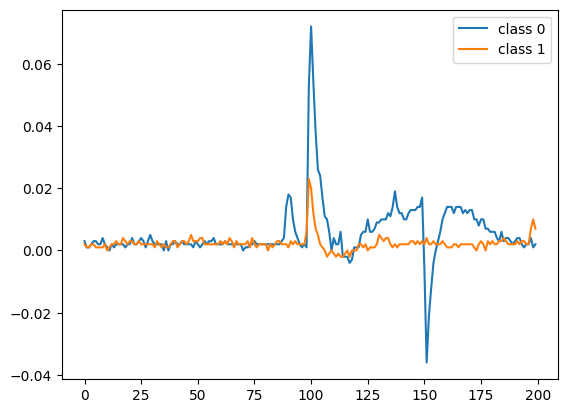

In [6]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

## Normalize the data

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(np.concatenate((x_train, x_test)))
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

## Standardize the data

In [8]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

num_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

## Build the CNN model

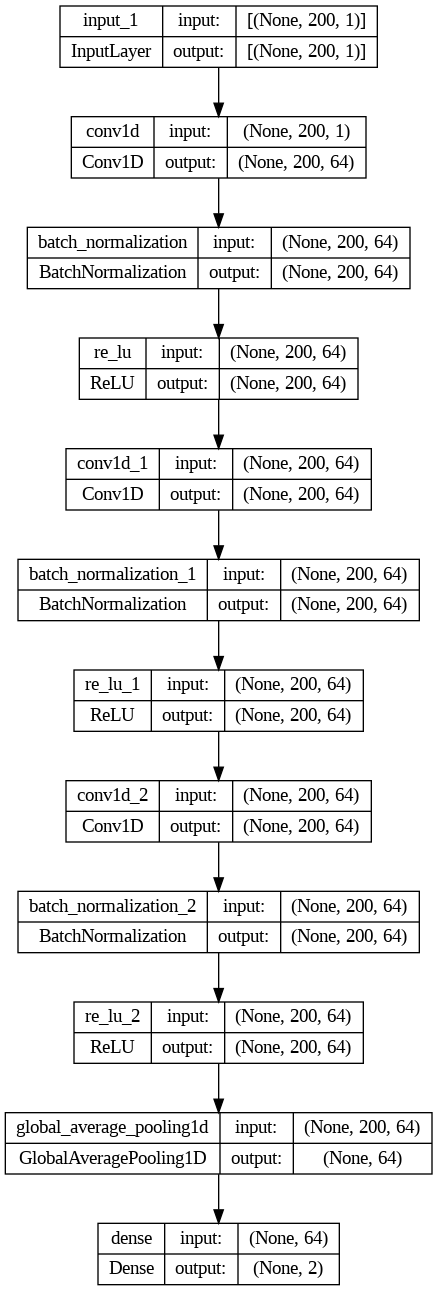

In [9]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [10]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_CNN.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
15/15 [==============================] - 17s 88ms/step - loss: 0.3066 - sparse_categorical_accuracy: 0.9379 - val_loss: 0.6639 - val_sparse_categorical_accuracy: 0.5575 - lr: 0.0010
Epoch 2/500
15/15 [==============================] - 0s 24ms/step - loss: 0.1677 - sparse_categorical_accuracy: 0.9823 - val_loss: 0.6686 - val_sparse_categorical_accuracy: 0.8673 - lr: 0.0010
Epoch 3/500
15/15 [==============================] - 0s 19ms/step - loss: 0.1377 - sparse_categorical_accuracy: 0.9823 - val_loss: 0.6761 - val_sparse_categorical_accuracy: 0.9115 - lr: 0.0010
Epoch 4/500
15/15 [==============================] - 0s 25ms/step - loss: 0.1229 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.6777 - val_sparse_categorical_accuracy: 0.5575 - lr: 0.0010
Epoch 5/500
15/15 [==============================] - 0s 24ms/step - loss: 0.1133 - sparse_categorical_accuracy: 0.9823 - val_loss: 0.6794 - val_sparse_categorical_accuracy: 0.5575 - lr: 0.0010
Epoch 6/500
15/15 [===============

## Evaluate the model on test data

In [11]:
model = keras.models.load_model("best_model_CNN.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

5/5 [==============================] - 0s 16ms/step - loss: 0.0474 - sparse_categorical_accuracy: 0.9859
Test accuracy 0.98591548204422
Test loss 0.04739361256361008


## Plot the model's traing and validation loss

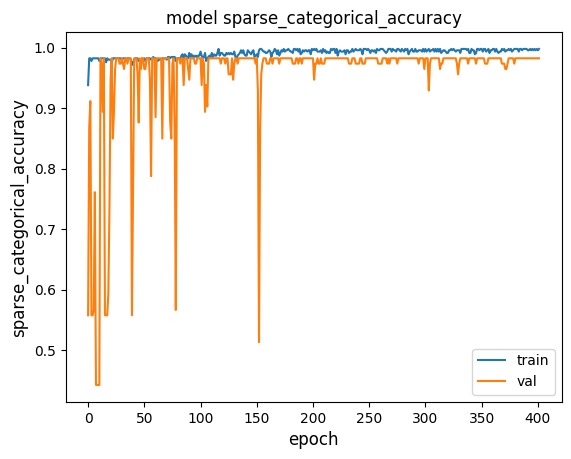

In [12]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

## Confusion matrix for the test data

In [21]:
# Infer the test data
y_pred = model.predict(x_test)
y_pred_binary = y_pred[:, 1] > y_pred[:, 0] # Convert one hot encoding probability array (N,2) to binary vector

# Create the confusion matrix
from sklearn.metrics import confusion_matrix

binary_classification_confusion_matrix = confusion_matrix(y_test, y_pred_binary)
print('Confusion matrix:')
print(binary_classification_confusion_matrix)


5/5 [==============================] - 0s 3ms/step
Confusion matrix:
[[55  0]
 [ 2 85]]
